In [481]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")

In [482]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [483]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((151, 22), (52, 22))

In [484]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

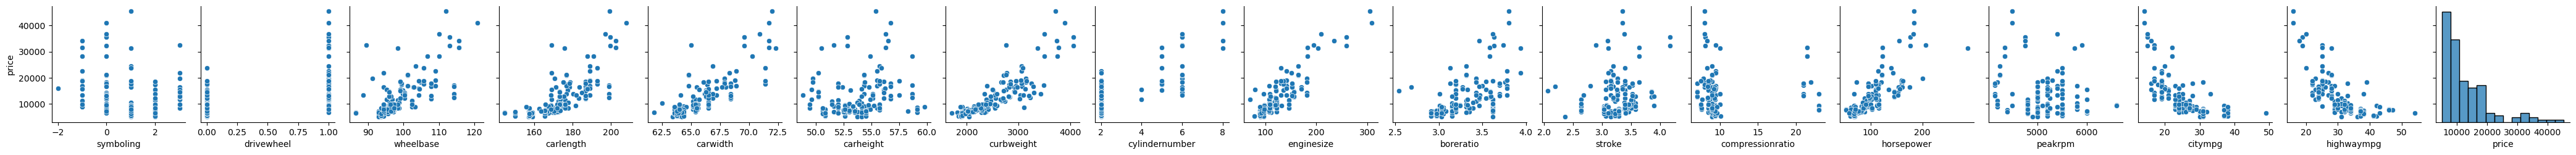

In [485]:
sns.pairplot(data=train_data[num_cols+["price"]].drop("car_ID").to_pandas(),y_vars="price")
plt.show()

In [486]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

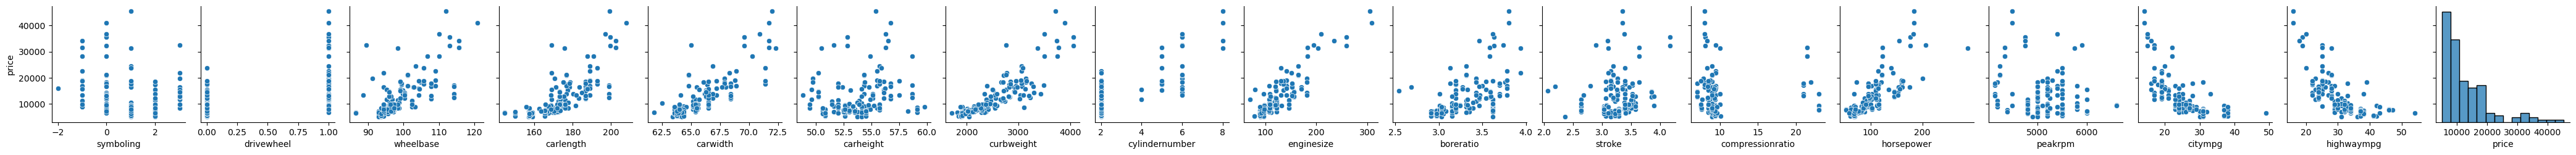

In [487]:
sns.pairplot(data=train_data.drop("car_ID").to_pandas(),y_vars="price")
plt.show()

In [488]:
import plotly.express as px
px.scatter(x=(train_data["enginesize"]*train_data['horsepower']*train_data["curbweight"]/train_data['peakrpm']),y=train_data['price'],color=train_data['price'])

In [489]:
px.scatter(x=(train_data['carlength']*train_data['carwidth']*train_data['carheight']),y=train_data['price'],color=train_data['price'])

In [490]:
px.scatter(x=1/((0.55/train_data['citympg'])+(0.45/train_data['highwaympg'])),y=train_data['price'],color=train_data['price'])

In [491]:
train_data=train_data.with_columns(((train_data['carlength']*train_data['carwidth']*train_data["carheight"])).alias("carvolume")).drop("carlength", "carwidth","carheight")
train_data=train_data.with_columns(((train_data["enginesize"]*train_data['horsepower']*train_data["curbweight"]/train_data['peakrpm'])).alias("enginepower")).drop("peakrpm","horsepower","enginesize","curbweight")
# US Environmental Protection Agency (EPA) uses a standard weighting of 55% city and 45% highway to calculate a combined fuel economy rating for vehicles https://www.epa.gov/fueleconomy
train_data=train_data.with_columns((1/((0.55/train_data['citympg'])+(0.45/train_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')

test_data=test_data.with_columns(((test_data['carlength']*test_data['carwidth']*test_data["carheight"])).alias("carvolume")).drop("carlength", "carwidth","carheight")
test_data=test_data.with_columns(((test_data["enginesize"]*test_data['horsepower']*test_data["curbweight"]/test_data['peakrpm'])).alias("enginepower")).drop("peakrpm","horsepower","enginesize","curbweight")
test_data=test_data.with_columns((1/((0.55/test_data['citympg'])+(0.45/test_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')

num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Feature Engineering (Gpt based Domain Knowledge)

In [492]:
# train_data=train_data.with_columns(pl.Series(train_data['horsepower']/train_data["curbweight"]).alias("powerToWeightRatio")).drop("horsepower","curbweight")
# train_data=train_data.with_columns(pl.Series(train_data['wheelbase']*train_data["carwidth"]*train_data["carheight"]).alias("interiorSpace")).drop("wheelbase","carwidth","carheight")
# train_data=train_data.with_columns(pl.Series(train_data['boreratio']/train_data["stroke"]).alias("performance")).drop("boreratio", "stroke")
# test_data=test_data.with_columns(pl.Series(test_data['horsepower']/test_data["curbweight"]).alias("powerToWeightRatio")).drop("horsepower","curbweight")
# test_data=test_data.with_columns(pl.Series(test_data['wheelbase']*test_data["carwidth"]*test_data["carheight"]).alias("interiorSpace")).drop("wheelbase","carwidth","carheight")
# test_data=test_data.with_columns(pl.Series(test_data['boreratio']/test_data["stroke"]).alias("performance")).drop("boreratio", "stroke")

# num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

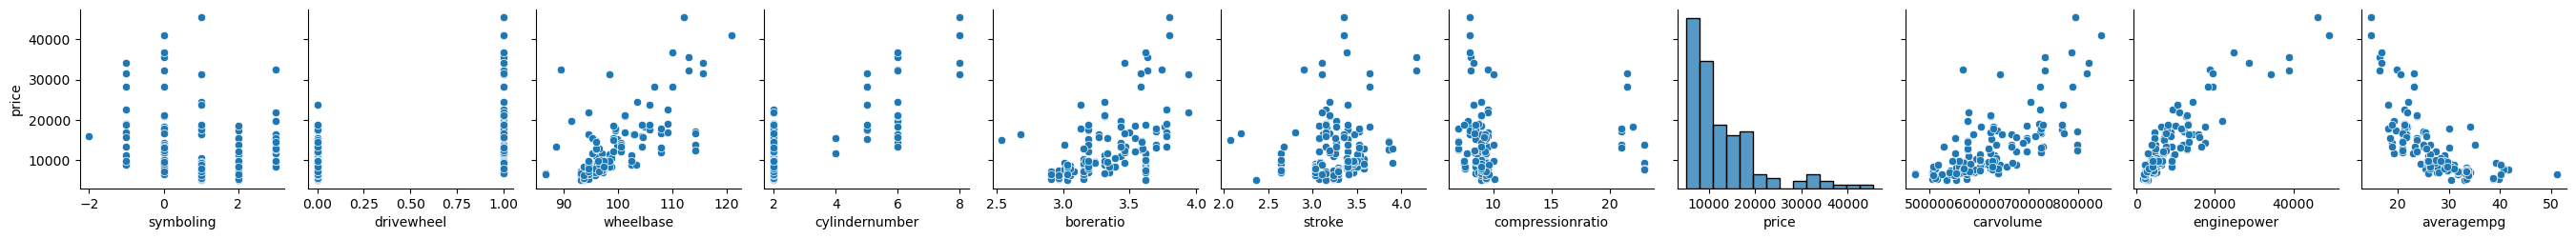

In [493]:
sns.pairplot(data=train_data.drop("car_ID").to_pandas(),y_vars="price")

# Having more domain knowledge may even make use of these remaining features like compression ratio,enginetype

<Axes: >

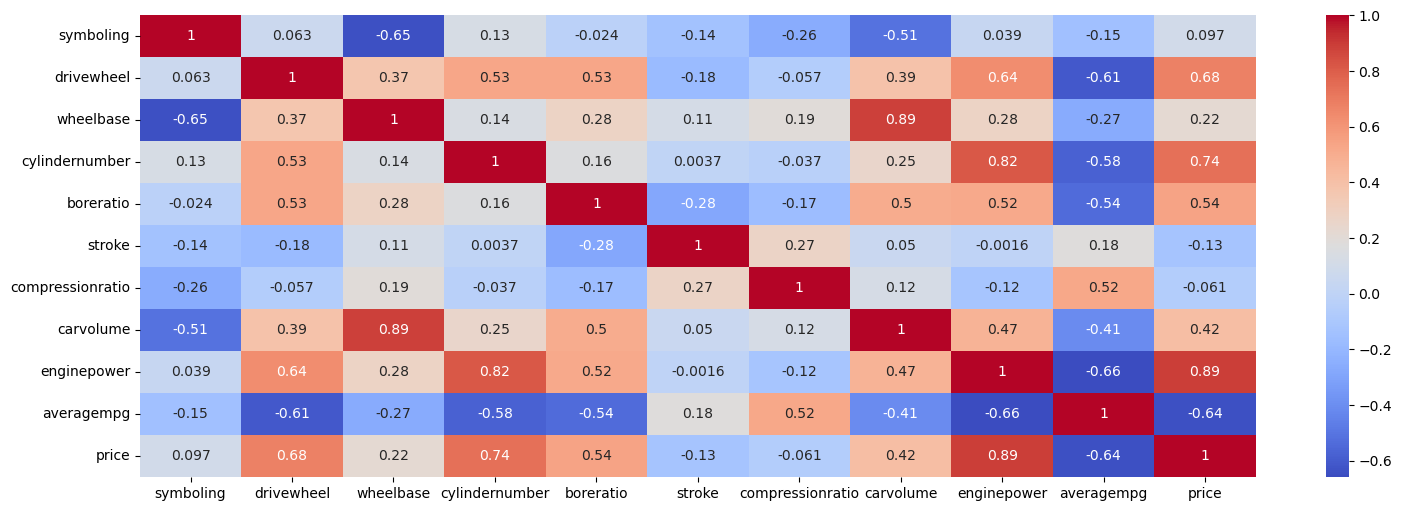

In [494]:
plt.figure(figsize=(18,6))
sns.heatmap(test_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap='coolwarm')

In [495]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2270.643415
3,wheelbase,9.152247
8,carvolume,8.795625
9,enginepower,6.441351
10,averagempg,4.474534


In [502]:
train_data=train_data.drop("wheelbase")
test_data=test_data.drop("wheelbase")
num_cols.remove("wheelbase")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,1271.249225
8,enginepower,5.953884
9,averagempg,4.472731
3,cylindernumber,4.106916
7,carvolume,3.808691


In [497]:
# train_data=train_data.drop("horsepower")
# test_data=test_data.drop("horsepower")
# num_cols.remove("horsepower")
# df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
# calculate_vif(df).sort_values(by='VIF',ascending=False).head()

In [498]:
# train_data=train_data.drop("boreratio")
# test_data=test_data.drop("boreratio")
# num_cols.remove("boreratio")
# df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
# calculate_vif(df).sort_values(by='VIF',ascending=False).head()

In [504]:
train_data.write_csv("../Day4_ErrorAnalysis/train_featureEngineered.csv")
test_data.write_csv("../Day4_ErrorAnalysis/test_featureEngineered.csv")

In [500]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler


imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=8), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=8),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'wheelbase',
                                                   'cylindernumber',
                                                   'boreratio', 'stroke',
                                                   'compressionratio',
                                                   'carvolume', 'enginepower',
                                                   'averagempg'])])),
                ('lr', LinearRegression())])

Test Scores: [0.85747846 0.8202934  0.86187333 0.81297986 0.86002782]
Training Scores: [0.92888472 0.92619207 0.9257796  0.92482581 0.92697467]
Mean Test Score: 0.8425305726162865
Standard Deviation of Test Scores: 0.021314181303779996
Mean absolute Error: 3008.557307366441
R-squared: 0.789016659949799


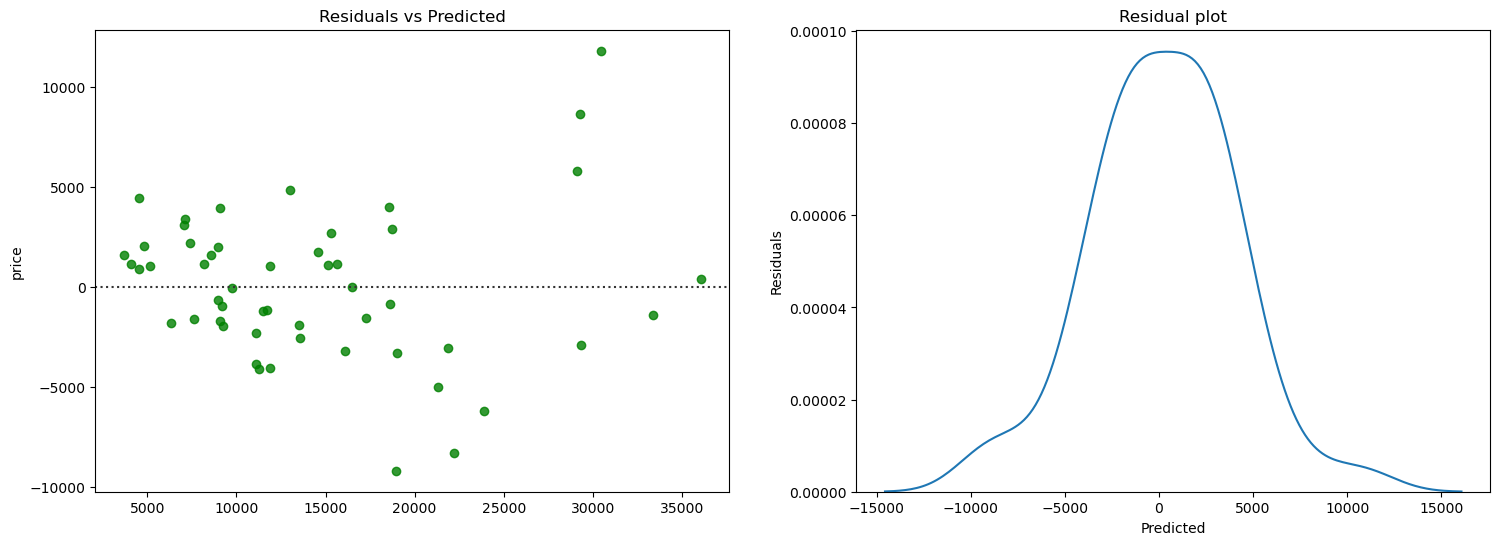

In [503]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,r2_score

train_df = train_data.to_pandas()
test_df = test_data.to_pandas()
X_train, X_test, y_train, y_test = train_df.drop(["price","car_ID"],axis=1),test_df.drop(["price","car_ID"],axis=1),train_df['price'],test_df['price']

kf=KFold(n_splits=5)
cv_results = cross_validate(pipe, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

predictions = cross_val_predict(pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)

print(f'Mean absolute Error: {mae}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# mean test score changed from 82 to 85

Residual range decreased little bit

### R2 score increased from 64 to 80 on holdout set and mean_absolute_error descreased from 3250 to 2509